(65, 7)
Pandas(Index=4, sample='HG00733', sample_batch=1, read_type='hifi', obs_hifi_cov=102.9, SIN='SIN:00733', norm_hifi_cov=99.5, diff=3.4000000000000057)
Pandas(Index=64, sample='NA24385', sample_batch=2, read_type='hifi', obs_hifi_cov=118.1, SIN='SIN:24385', norm_hifi_cov=36.8, diff=81.3)
(65, 7)
Pandas(Index=56, sample='NA18939', sample_batch=2, read_type='ont', obs_ont_cov=36.1, SIN='SIN:18939', norm_ont_cov=46.8, diff=-10.699999999999996)
Pandas(Index=64, sample='NA24385', sample_batch=2, read_type='ont', obs_ont_cov=194.0, SIN='SIN:24385', norm_ont_cov=0.0, diff=194.0)


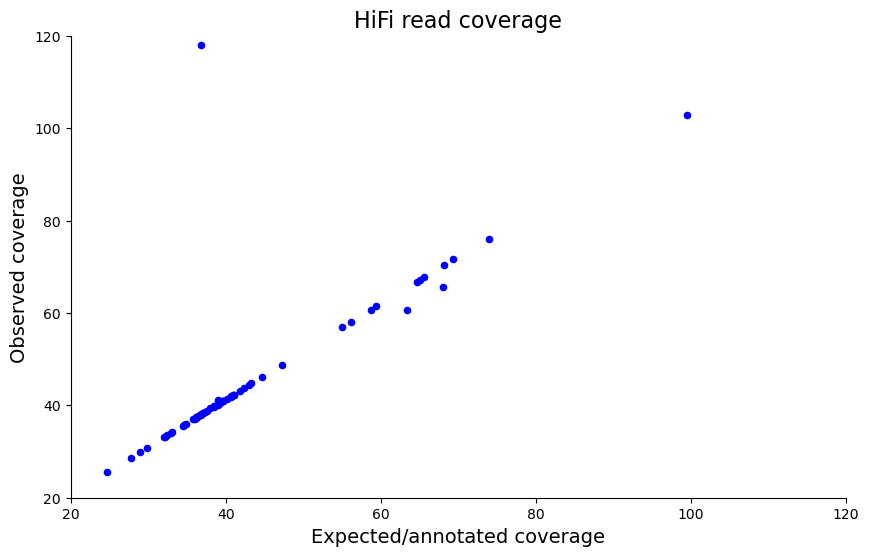

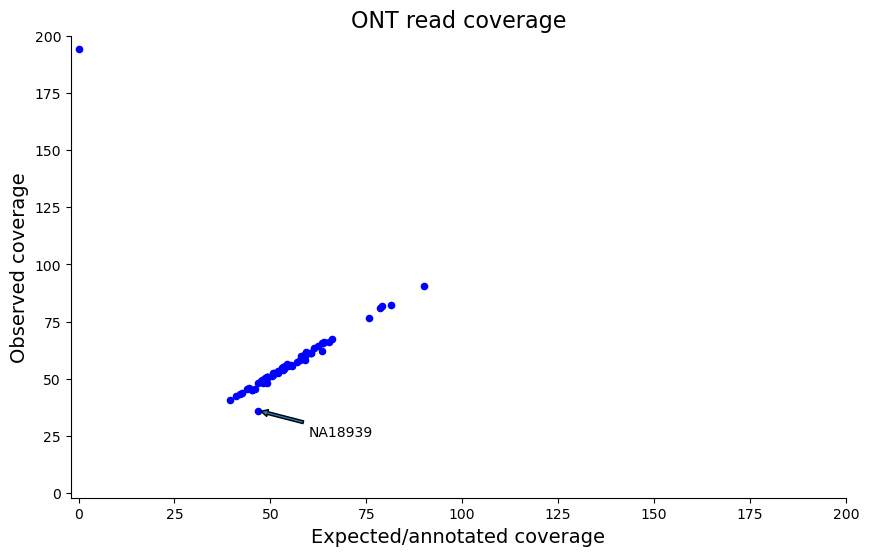

In [53]:
%run "../../00_project_config.ipynb"

import pathlib as pl

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

observed_cov = pd.concat(
    [
        pd.read_csv(
            PROJECT_DATA_ROOT.joinpath(
                "2023_batch_data_tables/hgsvc3_batch1_min_subset.tsv"
            ).resolve(strict=True),
            sep="\t", header=0, comment="#"
        ),
        pd.read_csv(
            PROJECT_DATA_ROOT.joinpath(
                "2023_batch_data_tables/hgsvc3_batch2_min_subset.tsv"
            ).resolve(strict=True),
            sep="\t", header=0, comment="#"
        ),
    ], axis=0, ignore_index=False
)

observed_cov["SIN"] = observed_cov["sample"].apply(lambda x: "SIN:" + x[2:])
observed_cov = observed_cov.loc[observed_cov["statistic"] == "cov_xfold_grt_0bp_at_3Gbp", :].copy()
observed_cov.drop(["source", "statistic"], axis=1, inplace=True)

annotated_cov = pd.read_csv(
    PROJECT_BASE.joinpath(
        "annotations", "projectmng", "master_data_cov.norm.tsv"
    ),
    header=0, comment="#", sep="\t"
)
annotated_cov["SIN"] = annotated_cov["sample"].apply(lambda x: "SIN:" + x[2:])
annotated_cov = annotated_cov.loc[~(annotated_cov == -1).any(axis=1), :].copy()

column_pairs = [
    ("HiFi", "norm_hifi_cov", "hifi"),
    ("ONT", "norm_ont_cov", "ont")
]

for label, exp_cov, obs_cov in column_pairs:
    
    exp_data = annotated_cov[["SIN", exp_cov]]
    exp_data = exp_data.loc[exp_data[exp_cov] > -1, :].copy()
    obs_data = observed_cov.loc[observed_cov["read_type"] == obs_cov, :].copy()
    obs_column = f"obs_{obs_cov}_cov"
    obs_data.rename({"value": obs_column}, inplace=True, axis=1)
        
    merged = obs_data.merge(exp_data, on="SIN", how="outer")
    merged["diff"] = merged[obs_column] - merged[exp_cov]
    print(merged.shape)
        
    fig, ax = plt.subplots(figsize=(10,6))
    
    ax.scatter(
        merged[exp_cov].values,
        merged[obs_column].values,
        c="blue",
        s=20
    )
    ax.set_xlabel("Expected/annotated coverage", fontsize=14)
    ax.set_ylabel("Observed coverage", fontsize=14)
    ax.set_title(f"{label} read coverage", fontsize=16)
    if label == "HiFi":
        ax.set_xlim(20, 120)
        ax.set_ylim(20, 120)
    if label == "ONT":
        ax.set_xlim(-2, 200)
        ax.set_ylim(-2, 200)
        ax.annotate(
            "NA18939",
            (46.8, 36.1),
            xytext=(60,25),
            arrowprops={"arrowstyle": "simple"}
            
        )
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    for row in merged.itertuples():
        if abs(row.diff) > 3:
            print(row)
    
    
